/Users/michaelruggiero/anaconda3/envs/liveramp/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/michaelruggiero/anaconda3/envs/liveramp/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
			 *** Episode 10 at Total Seconds 0.979457***
                         Average Reward for last 10 steps: 10.000000
                         Average Reward for all steps: 10.181818
                         Epsilon: 0.010508929792614355, Frames Total :112
                         Solved 0 Times
                      


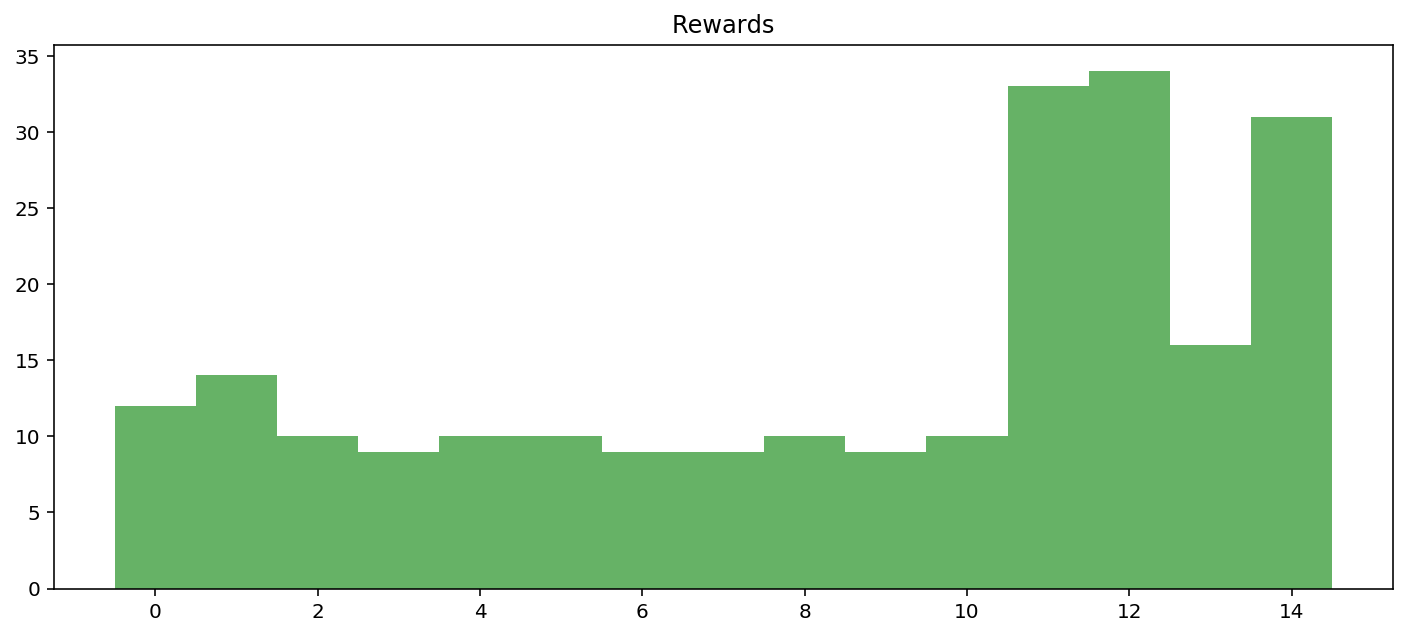

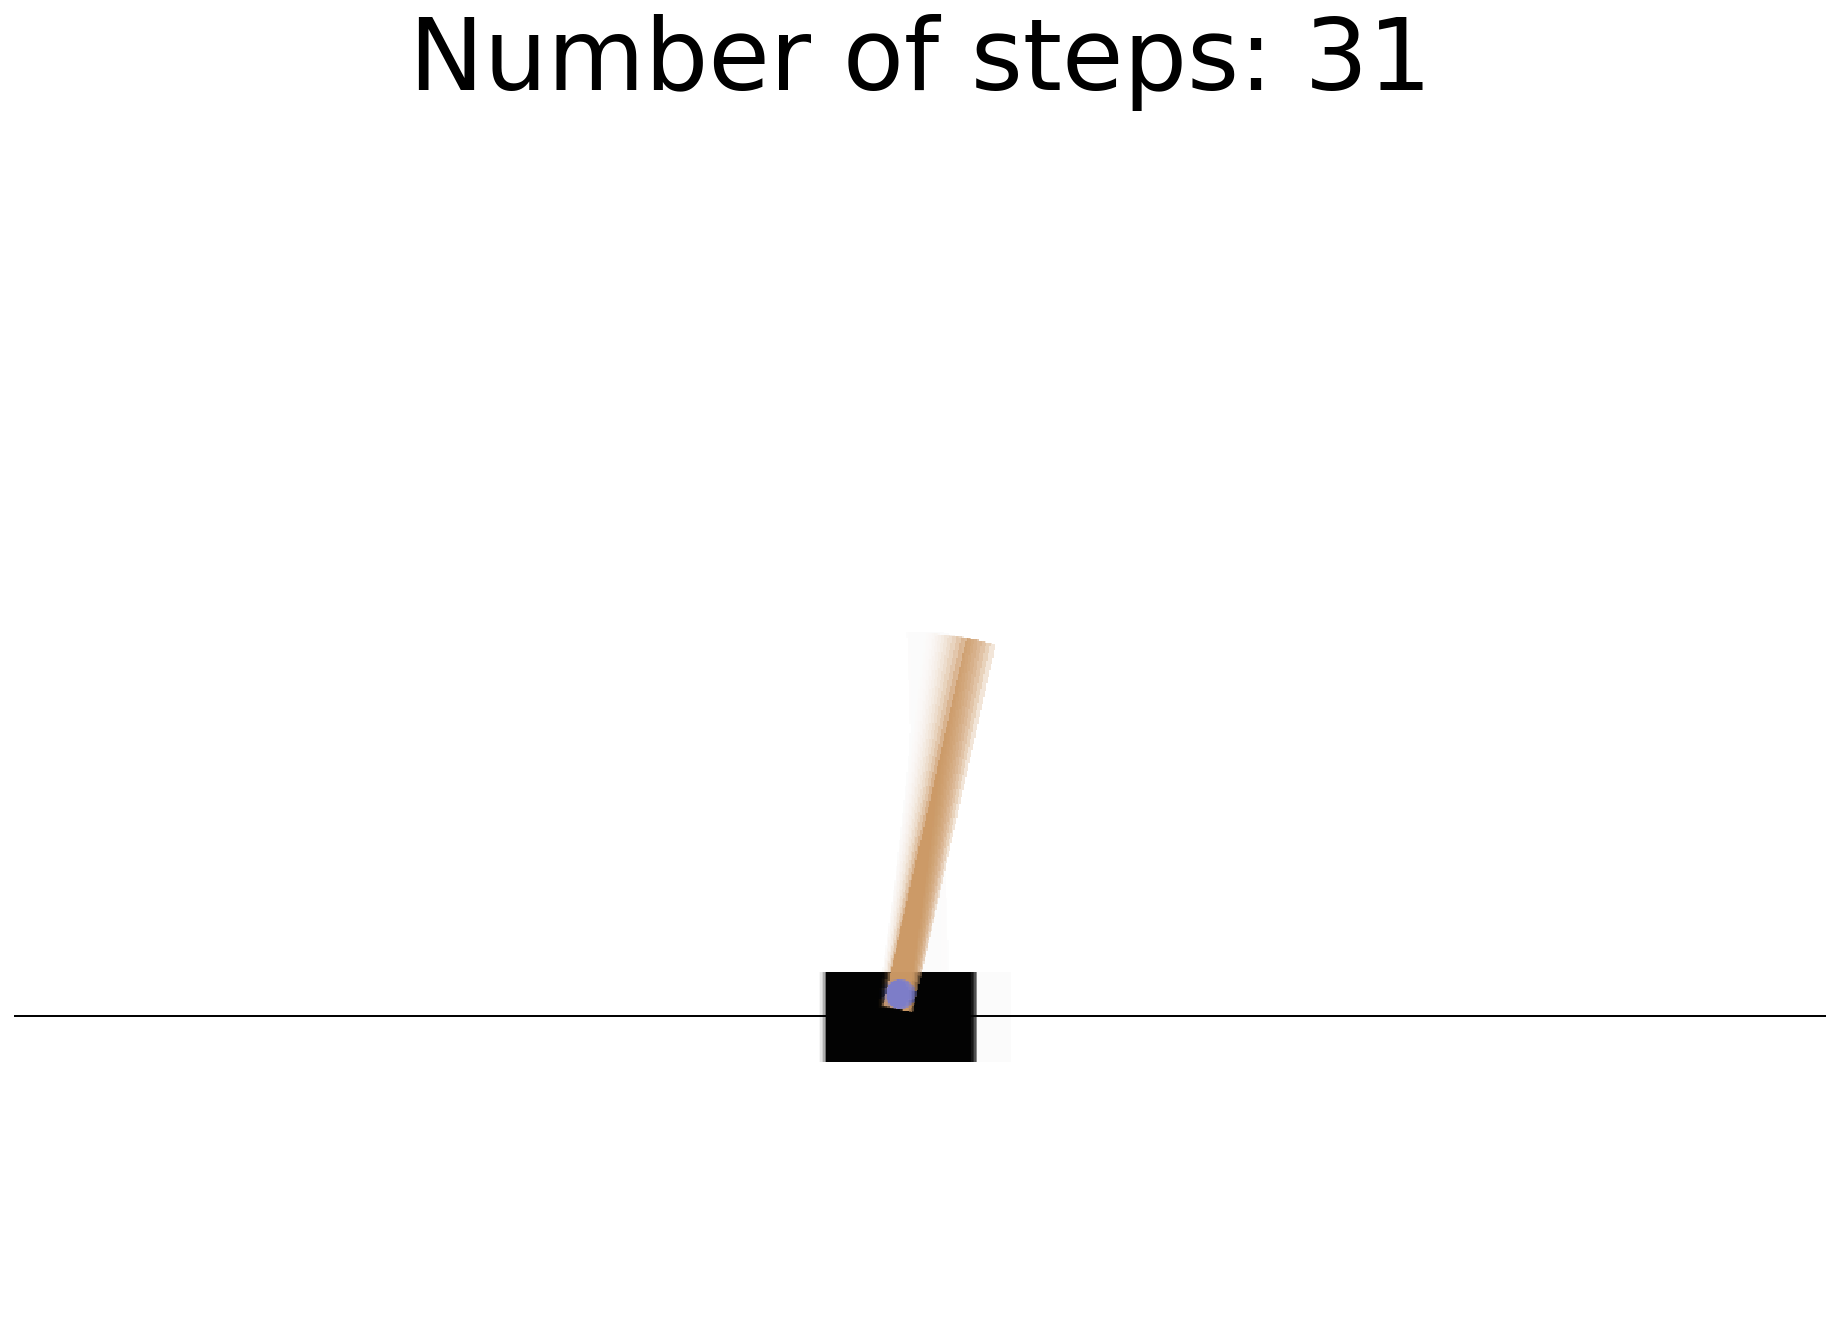

In [26]:
#Modified this code from https://nbviewer.jupyter.org/github/patrickmineault/
#xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from time import time
import gym
import math
%config InlineBackend.figure_format = 'retina'

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v0')

###### PARAMS ######
learning_rate = 0.02
num_episodes = 15
gamma = 0.99

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = num_episodes
report_interval = 10

hidden_layer = 64

score_to_solve = 195
solved = 0
####################

inputs = env.observation_space.shape[0]
outputs = env.action_space.n

# Having trouble with the following code after upgrading, will work on later. 
# TypeError: a bytes-like object is required, not 'str'
# def gif_maker(frames, title = ""):
#     plt.figure(figsize=(frames[0].shape[1] / 72.0,
#                frames[0].shape[0] / 72.0), dpi = 72)
#     patch = plt.imshow(frames[0])
#     plt.axis('off')
#     plt.title(title, fontdict={'fontsize': 50, 'fontweight': 'medium'})
    

#     def animate(i):
#         patch.set_data(frames[i])

#     anim = animation.FuncAnimation(plt.gcf(),
#                                    animate, 
#                                    frames = len(frames),
#                                    interval=50)
                                   
#     display(display_animation(anim, default_mode='loop'))

def display_frames(episode):
    plt.figure(figsize=(shadow_run[episode]["shots"][0].shape[1] / 72.0,
                        shadow_run[episode]["shots"][0].shape[0] / 72.0))
    
    for i in shadow_run[episode]["shots"]:
        plt.imshow(i, alpha = .25)
    plt.axis('off');
    plt.title("Number of steps: {}".format(shadow_run[episode]["steps"]),
              fontdict={'fontsize': 50, 'fontweight': 'medium'});

# Torch Template
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

#Code Borrowed heavily from Atamai Udemy Course
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,outputs)
        
        self.activation = nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
qnet_agent = QNet_Agent()

steps_total = []
frames_total = 0 
shadow_run = {}
start_time = time()


for episode in range(num_episodes):
    # Episode Initializations
    state = env.reset()
    shadow_run[episode] = {}
    actions, states, shots = [], [], []
    step = 0

    while True:
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)
        rendered = env.render(mode = 'rgb_array')
        
        # Agent Optimize
        qnet_agent.optimize(state, action, new_state, reward, done)

        # Store states for step
        actions.append(action)
        states.append(new_state)
        shots.append(rendered)
                  
        if done:
            steps_total.append(step)
            shadow_run[episode]["actions"] = actions
            shadow_run[episode]["states"] = states
            shadow_run[episode]["shots"] = shots
            shadow_run[episode]["steps"] = step
            
            if step >= score_to_solve: solved += 1
            
            if episode % report_interval == 0 and episode != 0:
                print("""\t\t\t *** Episode {} at Total Seconds {:2f}***
                         Average Reward for last {} steps: {:2f}
                         Average Reward for all steps: {:2f}
                         Epsilon: {}, Frames Total :{}
                         Solved {} Times
                      """.format(episode,
                           (time() - start_time),
                           str(report_interval),
                           sum(steps_total[-report_interval:])/report_interval,
                           sum(steps_total)/len(steps_total),
                           epsilon,
                           frames_total,
                           solved))
                    
            break
        
        state = new_state

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), 
        steps_total, 
        alpha=0.6, 
        color='green',
        width= 1)
plt.show()

env.close()
env.env.close()

#gif_maker(shadow_run[num_episodes - 1]["shots"], "Episode {}".format(num_episodes - 1))
display_frames(num_episodes-1)

In [6]:
gif_maker(shadow_run[num_episodes - 1]["shots"]

AttributeError: 'list' object has no attribute 'encode'

In [7]:
shadow_run[num_episodes - 1]["shots"]

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

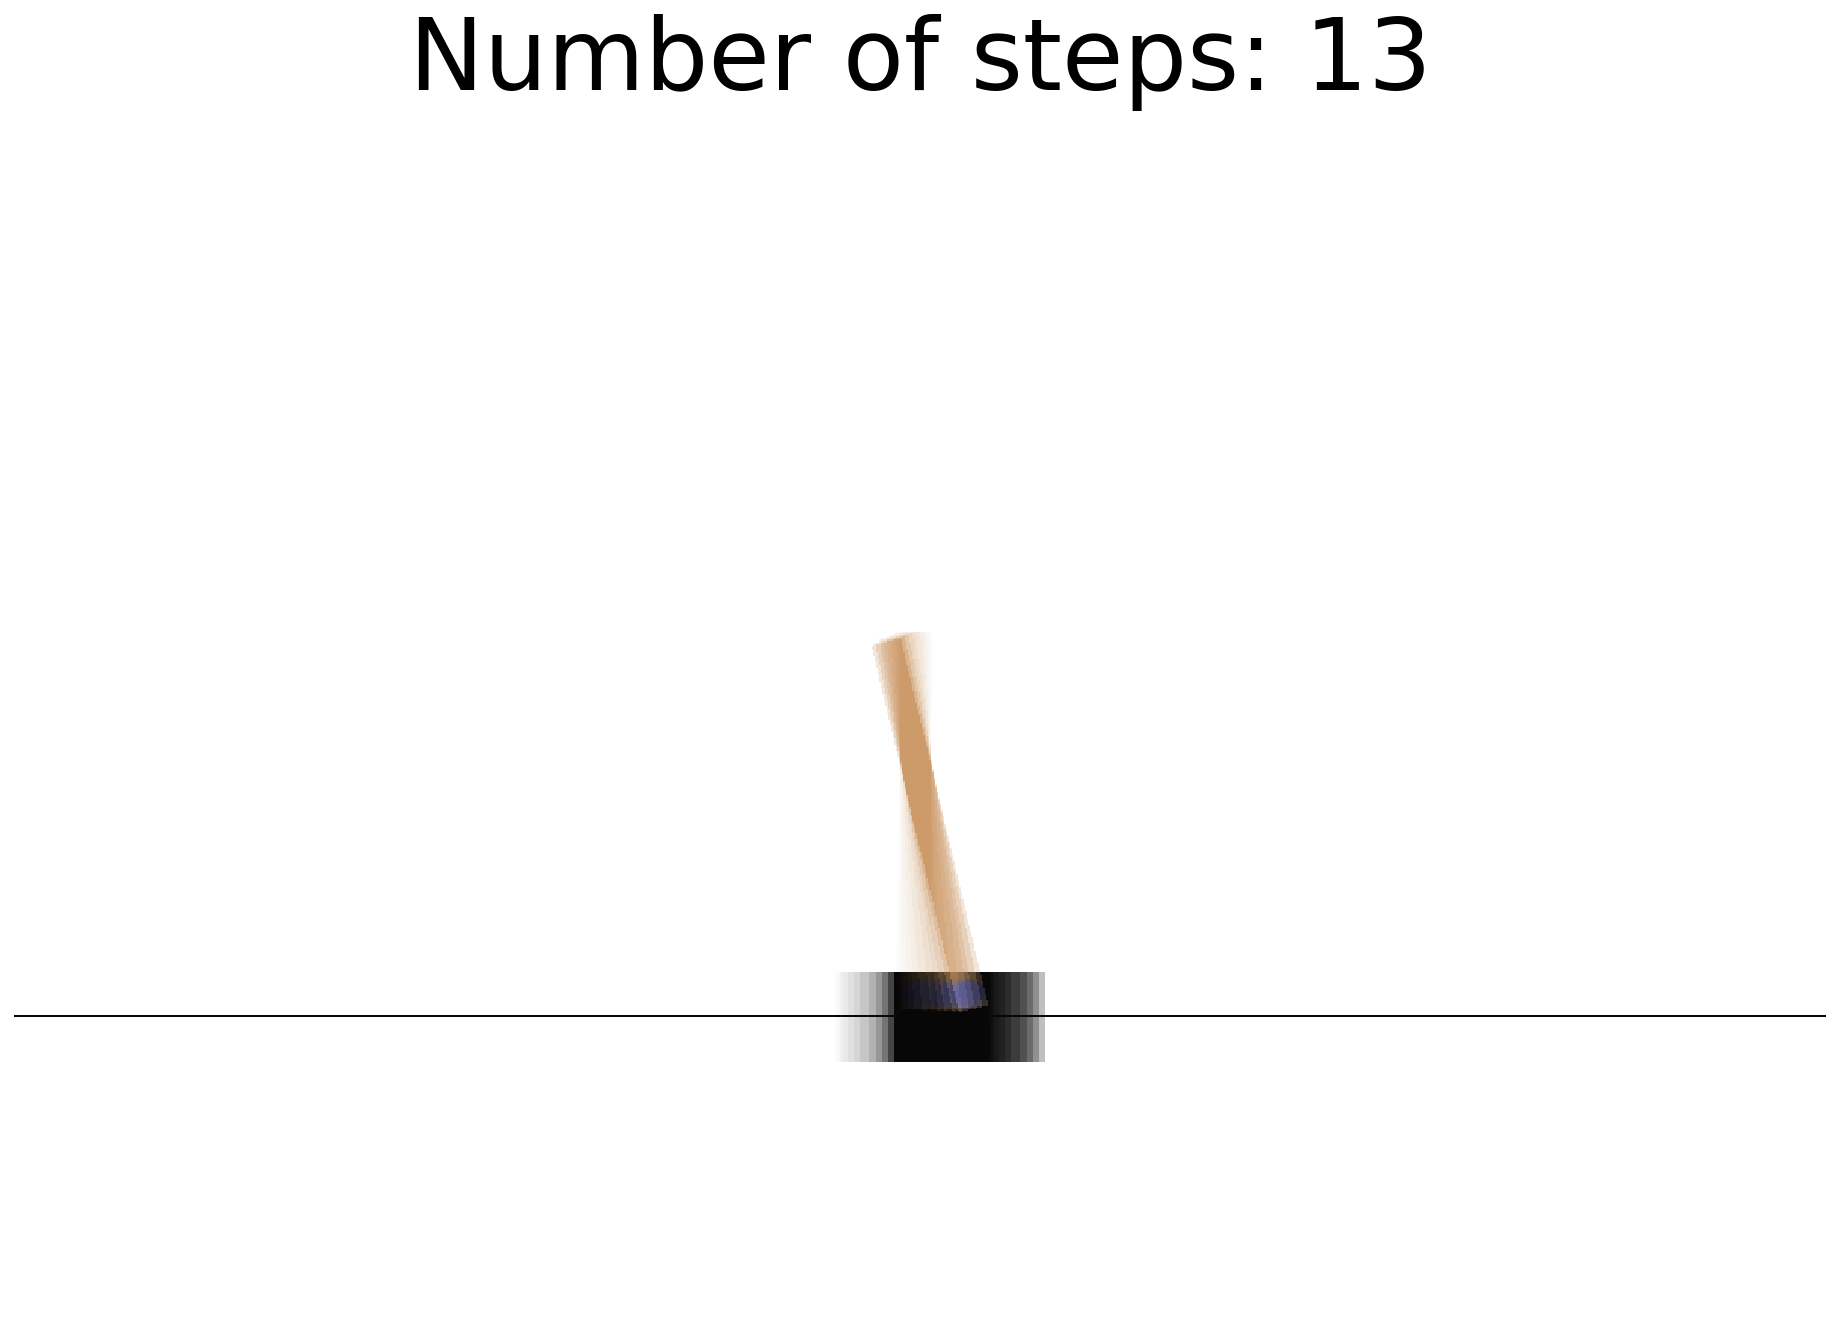

In [8]:
display_frames(num_episodes-1)

In [16]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import gym

env = gym.make('CartPole-v0')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
for t in range(1000):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim))

display_frames_as_gif(frames[0])

/Users/michaelruggiero/anaconda3/envs/liveramp/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


TypeError: a bytes-like object is required, not 'str'

In [13]:
frames[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

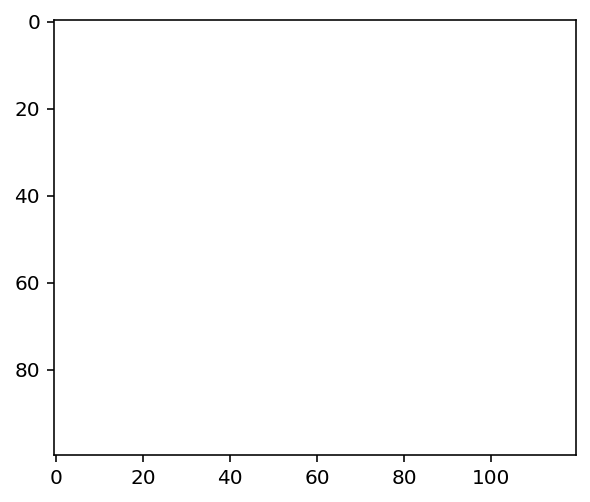

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=100)

# ani.save('dynamic_images.mp4')

plt.show()

In [21]:
ani

TypeError: a bytes-like object is required, not 'str'